_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 4)           0         
__________

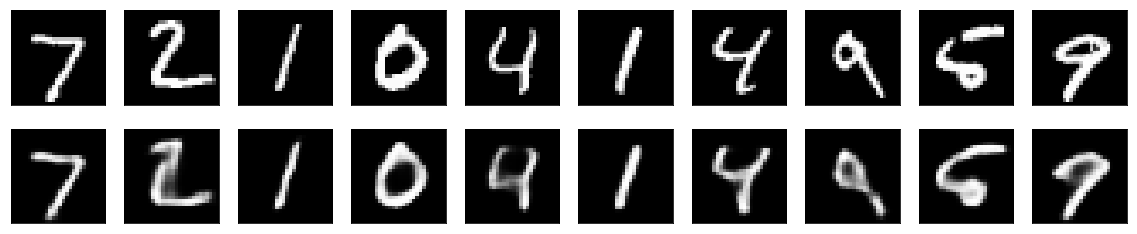

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras.callbacks import TensorBoard
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.datasets import mnist

input_encoder = Input(shape=(28, 28, 1))

def encoder(x):
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    maxpool1 = MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = Conv2D(4, (3, 3), activation='relu', padding='same')(maxpool2)
    maxpool3 = MaxPooling2D((2, 2), padding='same')(conv3)
    return maxpool3

input_decoder = Input(shape=(4, 4, 4))

def decoder(x):
    resize1 = UpSampling2D((2, 2))(x)
    conv1 = Conv2D(4, (3, 3), activation='relu', padding='same')(resize1)
    resize2 = UpSampling2D((2, 2))(conv1)
    conv2 = Conv2D(8, (3, 3), activation='relu')(resize2)
    resize3 = UpSampling2D((2, 2))(conv2)
    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(resize3)
    return Conv2D(1, (5, 5), activation='sigmoid', padding='same', name="decoder_output")(conv3)

autoencoder = Model(input_encoder, decoder(encoder(input_encoder)))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print(autoencoder.summary())

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

encoder = autoencoder.layers[1](input_encoder)
encoder = autoencoder.layers[2](encoder)
encoder = autoencoder.layers[3](encoder)
encoder = autoencoder.layers[4](encoder)
encoder = autoencoder.layers[5](encoder)
encoder = autoencoder.layers[6](encoder)
encoder = Model(input_encoder, encoder)
print(encoder.summary())

decoder = autoencoder.layers[-7](input_decoder)
decoder = autoencoder.layers[-6](decoder)
decoder = autoencoder.layers[-5](decoder)
decoder = autoencoder.layers[-4](decoder)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(input_decoder, decoder)
print(decoder.summary())

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
import json
with open('autoencoder.json', 'w') as outfile:
    outfile.write(autoencoder.to_json())
with open('encoder.json', 'w') as outfile:
    outfile.write(encoder.to_json())
with open('decoder.json', 'w') as outfile:
    outfile.write(decoder.to_json())
    
autoencoder.save_weights("autoencoder.h5")
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")